In [2]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

# Import Weeds Data

In [33]:
# Read the Shp file
gdf = gpd.read_file("quads3310-20131231.shp")
print(gdf.head())


       ID  SPECIES_ID  QUAD_ID                  SPECIES          QUAD_NAME  \
0  552874         101      514  Zantedeschia aethiopica       CALNEVA LAKE   
1  552875         101      639  Zantedeschia aethiopica            CALPINE   
2  552876         101     2319  Zantedeschia aethiopica       CALUMET MINE   
3  552877         101     2360  Zantedeschia aethiopica  CALUMET MOUNTAINS   
4  552878         101     1748  Zantedeschia aethiopica    CALVADA SPRINGS   

   ABUNDANCE  SPREAD                  ABUNSPREAD   MANAGEMENT        DATE  \
0          0       0  Suspected absent from quad  not managed  2011-06-27   
1          0       0  Suspected absent from quad  not managed  2011-06-27   
2          0       0  Suspected absent from quad  not managed  2011-09-13   
3          0       0  Suspected absent from quad  not managed  2011-09-13   
4          0       0  Suspected absent from quad  not managed  2011-06-30   

  SOURCE                                         PARTICIPAN OBS_NOTE

0         False
1         False
2         False
3         False
4         False
          ...  
555343    False
555344    False
555345    False
555346    False
555347    False
Name: SPECIES_ID, Length: 555348, dtype: bool

In [ ]:
print("Columns in DS:\n", gdf.columns)
first_row = gdf.iloc[0]
print("First row\n", first_row)

weeds = gdf[['ID', 'SPECIES', 'SPECIES_ID', 'QUAD_ID', 'ABUNDANCE',
       'SPREAD', 'DATE', 'geometry']]

weeds = weeds[weeds['ABUNDANCE'] != 9] #Remove species which couldn't be properly identified


print(f"Num Species: {len(list(set(weeds['SPECIES_ID'])))}, Num Regions: {len(list(set(weeds['QUAD_ID'])))}")

Columns in DS:
 Index(['ID', 'SPECIES_ID', 'QUAD_ID', 'SPECIES', 'QUAD_NAME', 'ABUNDANCE',
       'SPREAD', 'ABUNSPREAD', 'MANAGEMENT', 'DATE', 'SOURCE', 'PARTICIPAN',
       'OBS_NOTES', 'OB_VALUE', 'geometry'],
      dtype='object')
First row
 ID                                                       552874
SPECIES_ID                                                  101
QUAD_ID                                                     514
SPECIES                                 Zantedeschia aethiopica
QUAD_NAME                                          CALNEVA LAKE
ABUNDANCE                                                     0
SPREAD                                                        0
ABUNSPREAD                           Suspected absent from quad
MANAGEMENT                                          not managed
DATE                                                 2011-06-27
SOURCE                                                     None
PARTICIPAN    Allison Sanger, Craig Hemphill, Josh

Text(0.5, 1.0, 'Species Distribution Across Quads')

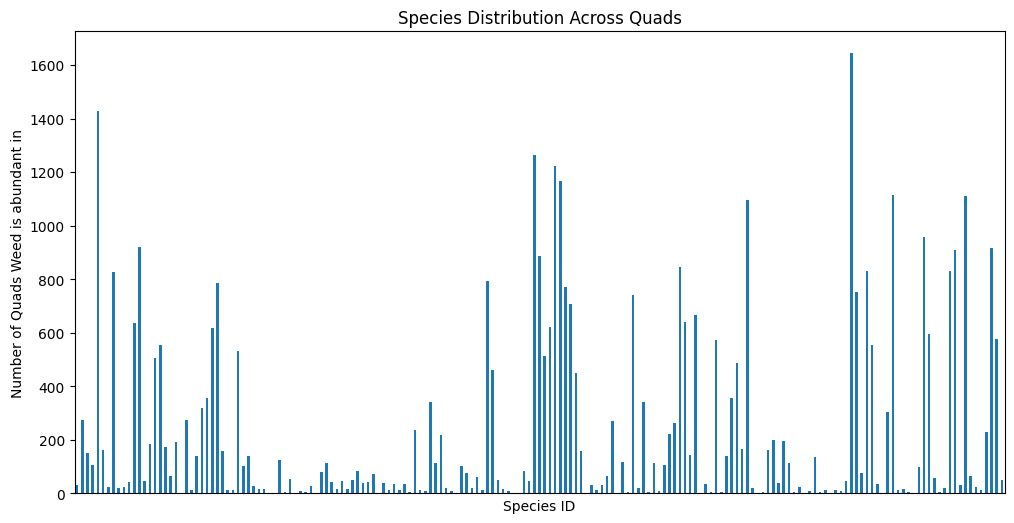

In [ ]:

# Group by species_id and count number of unique quad_ids
species_quad = weeds[weeds["ABUNDANCE"] > 1].groupby("SPECIES_ID")["QUAD_ID"].nunique()

# Plot bar chart
plt.figure(figsize=(12, 6))
species_quad.plot(kind="bar")
plt.xticks([], [])
plt.xlabel("Species ID")
plt.ylabel("Number of Quads Weed is abundant in")
# plt.yscale("log")
plt.title("Species Distribution Across Quads")

# Import Fire Data

In [9]:
california = gpd.read_file("CA_State.shp")
california = california.to_crs(epsg = 3857)
fires = gpd.read_file("Perimeters.shp")
fires = fires[fires.is_valid]
fires = fires.to_crs(epsg = 3857)

## Filter for California Only

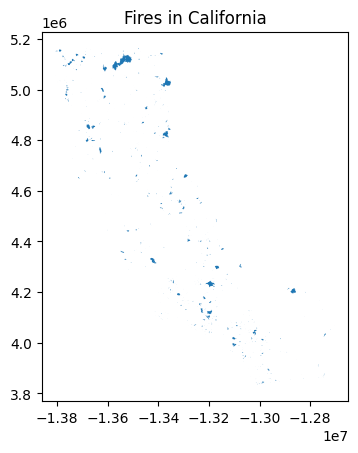

In [10]:
intersection = gpd.sjoin(fires, california, how='inner') # keep only the fires that are in in california
intersection.plot()
plt.title("Fires in California")
plt.show()

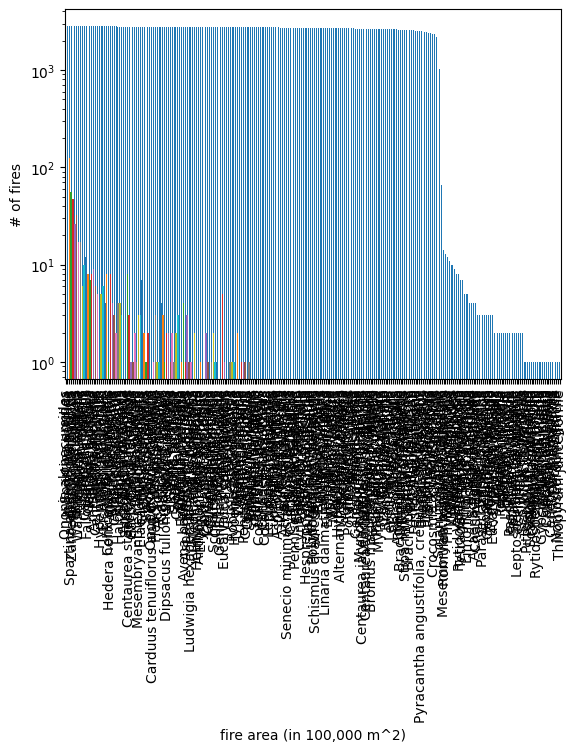

In [11]:
intersection["area"] = intersection.geometry.area #computes the area of each geometry in the intersection GeoDataFrame and stores it in a new column called "area".

weeds_by_name = weeds['SPECIES'].value_counts()
weeds_by_name.plot(kind = 'bar')

reigons = [i*(100000) for i in range(101)]


for i in range(1, 101):
    plt.bar(i, len(intersection[intersection["area"]<=reigons[i]][intersection["area"]>reigons[i-1]]))

plt.bar(i, len(intersection[intersection["area"]>reigons[-1]]))

plt.xlabel("fire area (in 100,000 m^2)")
plt.ylabel("# of fires")
plt.yscale("log")
plt.show()

In [12]:
#For each weed, if a fire was in a quad and the weed was in a quad, +1
weeds_by_species = weeds[weeds["ABUNDANCE"] > 1].to_crs(intersection.crs)
weeds_by_name = weeds['SPECIES']
weeds_by_name.to_csv('weeds_by_name.csv')


for i in range(len(intersection)):
    weeds_by_species[f"intersects_target {i}"] = weeds_by_species.geometry.intersects(intersection.geometry.iloc[i]).astype(int)

In [13]:
weeds_by_species["fires"] = weeds_by_species[[f"intersects_target {i}" for i in range(len(intersection))]].sum(axis = 1)

# print(sum(weeds_by_species[weeds_by_species["SPECIES_ID"] == 1]["fires"]))

species_fire_count = [sum(weeds_by_species[weeds_by_species["SPECIES_ID"] == i]["fires"]) for i in list(set(weeds_by_species["SPECIES_ID"]))]
species_fire_count[0]

19

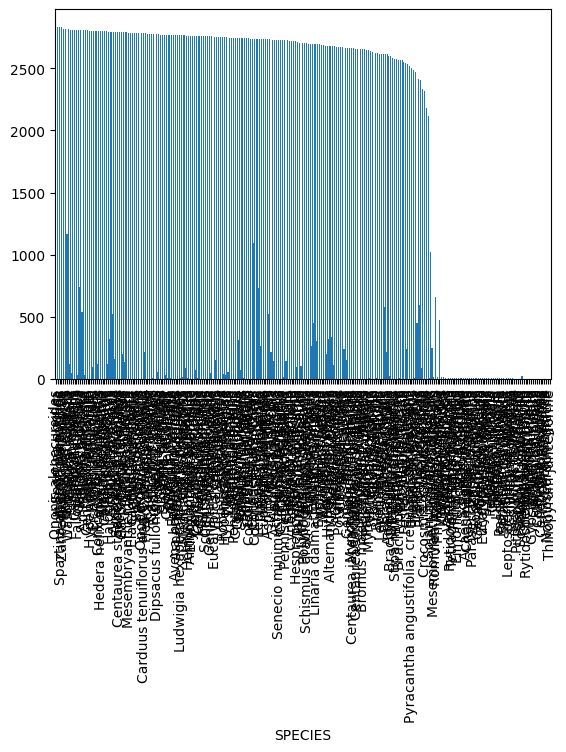

294       101
644       101
1186      101
1517      101
1518      101
         ... 
554664    100
554923    100
554945    100
555228    101
555278    101
Name: SPECIES_ID, Length: 41690, dtype: int64
Species ID: 75, Species Name: Euphorbia terracina, Fires: 74
Species ID: 175, Species Name: Halogeton glomeratus, Fires: 74


In [ ]:
weeds_by_name = weeds['SPECIES'].value_counts()
weeds_by_name.plot(kind='bar')

plt.bar(list(set(weeds_by_species["SPECIES_ID"])), species_fire_count)
plt.show()



# Certain Weeds cause more Fires

Line of best fit equation y = 0.7546306128938004x + -4.125979058896888 

Top 5 Error Species
                   species  species_id  observed_fires  predicted_fires  \
118      Ricinus communis         138             450       103.031568   
11   Centaurea melitensis          13             736       476.573721   
92        Bromus diandrus         111            1173       917.277999   
129        Festuca myuros         149            1073       823.703803   
113   Pennisetum setaceum         133             303        75.110235   

      residuals  
118  346.968432  
11   259.426279  
92   255.722001  
129  249.296197  
113  227.889765  


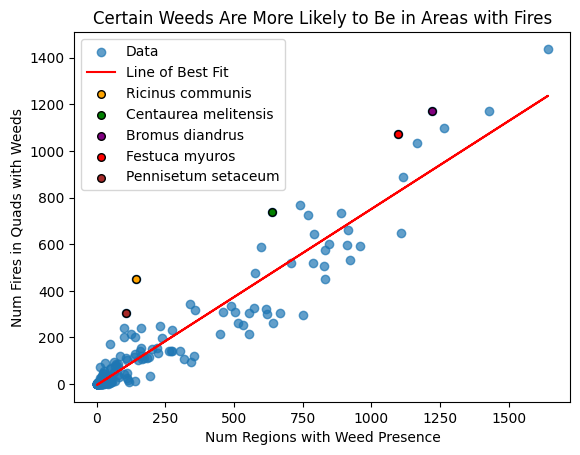

the metric "Num Fires in Quads with Weeds" represents the number of fires that occurred in the geographic regions (quads) where a specific weed species is present


In [ ]:
X = np.array(species_quad).reshape(-1, 1)  # Independent variable (number of regions with weed presence)
y = np.array(species_fire_count)          # Dependent variable (number of fires)

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
m = model.coef_[0]
b = model.intercept_

# Calculate residuals (errors)
residuals = y - y_pred
print("Line of best fit equation", f"y = {m}x + {b} \n")

# For each species_id, get the first species name (assuming one-to-one mapping)
species_names = [weeds_by_species[weeds_by_species["SPECIES_ID"] == sid]["SPECIES"].iloc[0] for sid in species_ids]
species_ids = species_quad.index.tolist()

# Error Dataframe
error_data = pd.DataFrame({
    "species": species_names,
    "species_id" : species_ids,
    "observed_fires": y,
    "predicted_fires": y_pred,
    "residuals": residuals
})

# Sort by absolute residuals in descending order and select the top 5
top5_error_species = error_data.reindex(error_data["residuals"].sort_values(ascending=False).index).head(5)
print("Top 5 Error Species\n", top5_error_species)

plt.scatter(X, y, label="Data", alpha=0.7)
plt.plot(species_quad, y_pred, color="red", label="Line of Best Fit")  # Add the line of best fit
# Highlight the species with the highest error

# Define a list of distinct colors for the top 5
top5_colors = ["orange", "green", "purple", "red", "brown"]

# Highlight and label the top 5 species with the highest error
for i, (idx, row) in enumerate(top5_error_species.iterrows()):
    plt.scatter(
        X[idx], y[idx],
        color=top5_colors[i % len(top5_colors)], s=30, edgecolor="black",
        label=row["species"]
    )



plt.title("Certain Weeds Are More Likely to Be in Areas with Fires")
plt.xlabel("Num Regions with Weed Presence")
plt.ylabel("Num Fires in Quads with Weeds")
plt.legend()
plt.show()

print('the metric "Num Fires in Quads with Weeds" represents the number of fires that occurred in the geographic regions (quads) where a specific weed species is present')

Data on most overrepresented species
             species_id              species  observed_fires  expected_fires  \
SPECIES_ID                                                                    
75                  75  Euphorbia terracina              74        0.439314   

            fire_ratio  
SPECIES_ID              
75          168.444444  


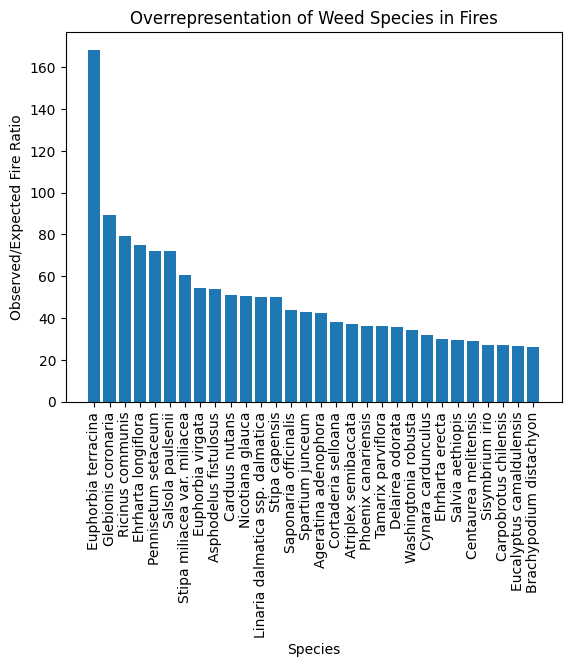

In [ ]:
# Total number of fires
total_fires = len(intersection) #intersection is fires in California

# Proportion of quads occupied by each species
species_proportion = species_quad / species_quad.sum()

# Expected number of fires for each species
expected_fires = species_proportion * total_fires

# Calculate the ratio of observed to expected fires
fire_ratio = species_fire_count / expected_fires



# Create a DataFrame for analysis
flammability_data = pd.DataFrame({
    "species_id": species_ids,
    "species": species_names,
    "observed_fires": species_fire_count,
    "expected_fires": expected_fires,
    "fire_ratio": fire_ratio
})


# Sort by fire ratio to find the most overrepresented species
flammability_data = flammability_data.sort_values(by="fire_ratio", ascending=False)
flammability_data = flammability_data[:30]

print("Data on most overrepresented species\n", flammability_data.head(1))

plt.bar(flammability_data["species"], flammability_data["fire_ratio"])
plt.xlabel("Species")
plt.xticks(rotation=90)  # Make x-axis labels vertical
plt.ylabel("Observed/Expected Fire Ratio")
plt.title("Overrepresentation of Weed Species in Fires")
plt.show()
